# Fitting discrete distributions with weights

Here, I outline the strategy for fitting the underlying distribution from discretized data points that have weights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np
import itertools
import time

### Simulate some data

In [15]:
# Parameters
num_cells = 1000
p = 0.1
mu = 10
sigma = 3

In [16]:
continuous = np.random.normal(mu, sigma, size=num_cells)

In [17]:
ground_truth_counts = np.clip(np.round(continuous), a_min=0, a_max=100).astype(np.int64)

In [19]:
pd.Series(ground_truth_counts).value_counts()

10    133
9     123
11    119
12    117
8     110
13     78
7      76
14     55
6      48
15     37
5      31
4      26
16     19
17     11
3       7
19      3
20      2
0       2
18      1
2       1
1       1
dtype: int64

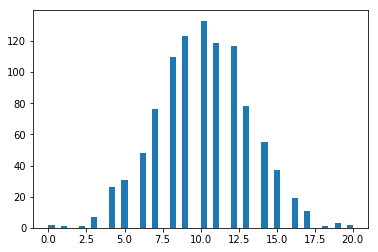

In [18]:
plt.hist(ground_truth_counts, bins=50);

In [9]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

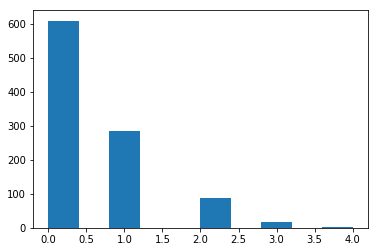

In [11]:
plt.hist(observed);

###